# **04. Plotting a Decision Plot**

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [28]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

Once HDX reweighting with a diverse range of gamma is complete, we can plot a decision plot, also know as an 'L-curve' using HDX reweighting output files. The shape of an 'L-curve' plot can aid the our decision of which gamma is reasonable without inducing overfitting. 

Choosing a reasonable gamma is important as it informs us which set of reweighting data to use for further analyses. 

This notebook describes how to plot a decision plot and analyze it.

### **Reading in HDX reweighting work output files to plot an L-curve**

In [30]:
def plot_lcurve(title):
    li = []
    for i in np.arange(-3, 1): # Select the range of gamma (i in j*10^i)
        for j in np.arange(1, 10): # Select the range of gamma (j in j*10^i)
            # Read files containing work values from the smallest to the biggest gamma
            try:
                work = os.path.expandvars(f'$HDXER_PATH/protocol/BPTI/BPTI_reweighting/reweighting_gamma_{j}x10^{i}_work.dat')
                df = pd.read_csv(work, comment='#', header=None, sep='\s+')
                li.append(df)
            except FileNotFoundError:
                pass
    works = pd.concat(li, axis=0, ignore_index=True) 
    works.columns = ['gamma', 'MSE', 'RMSE', 'work']
    
    plt.figure(figsize=(11, 8.5))
    plt.plot(works['MSE'], works['work'], color='teal', linewidth=3, markersize=10, marker='o')
    gamma_1_x = works[works['gamma'] == 1.0]['MSE']
    gamma_1_y = works[works['gamma'] == 1.0]['work']
    #plt.annotate("Gamma = 1.0", xy=(gamma_1_x, gamma_1_y), xytext=(gamma_1_x + 0.005, gamma_1_y + 2.0),
    #             arrowprops=dict(facecolor='black', shrink=0.05), size=12 )
    plt.title(title)
    plt.xlabel('MSE to target data')
    plt.ylabel('W$_{app}$ / kJ mol$^{-1}$')

### **Plotting and analyzing an L-curve**

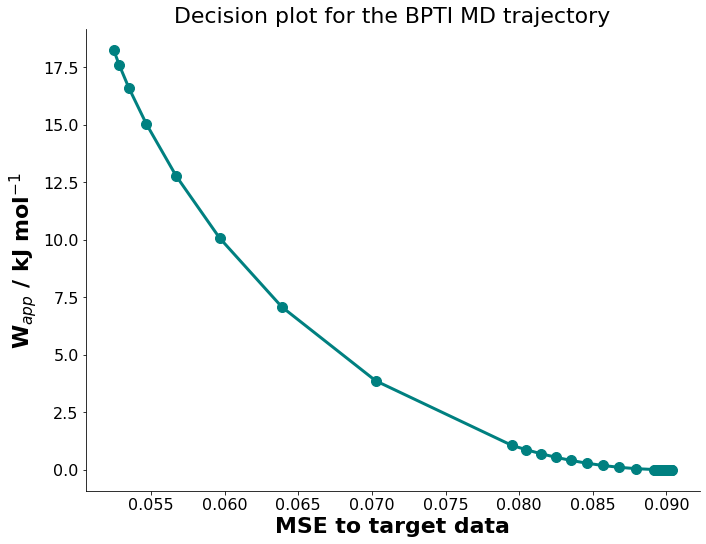

In [31]:
plot_lcurve('Decision plot for the BPTI MD trajectory')

Overfitting, in the context of HDX reweighting, implies a final structural ensemble that is fit too closely to the target HDX data, beyond the true level of uncertainty present. Overfitting would therefore result in an unreliable model of the true structural ensemble. This can also be thought of as 'fitting to noise', where the 'noise' can stem from either experimental, forward model, or sampling inadequacies, as discussed in notebook 3.

'Fitting to noise' can also be identified as a situation in which the accuracy of the fitted model becomes insensitive to large changes in the underlying model parameters - in this case the weights of each frame in the ensemble. This may be simply characterized as a reweighting that results in a large increase in applied bias (apparent work), for little improvement in accuracy to the target data.

A sensible strategy to choose a suitable gamma value is therefore to plot the apparent work applied during each reweighting experiment, against the mean square deviation between the final predicted and target data, and to look for a sharp increase in work. An additional cutoff metric can be applied to the work value to keep the applied bias within a reasonable range (say, 2-3 $k_BT$. Here, we keep the work value below 3 kJ mol$^{-1}$. 

Here we chose a gamma value of $1*10^0$ based on the plot above.

### **Plotting deuterated fractions**

Now, let's visualize reweighted HDX deuterated fractions together with experimental and predicted HDX deuterated fractions.

In [ ]:
times = np.array([0.167, 1.0, 10.0, 120.0]) # Create a NumPy array with time points in minutes

In [ ]:
def read(file):
    """Read and create a pandas DataFrame for the given argument.
    
    Args:
        file: There are four possible options:
                'segs' - residue segments
                'expt' - experimental HDX deuterated fractions
                'pred' - predicted HDX deuterated fractions
                'reweighted' - reweighted HDX deuterated fractions
    
    Returns:
        df: A pandas DataFrame containing data for the given argument.
    """
    if file == 'segs':
        # Read and create a pandas DataFrame using a residue segments file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_residue_segs.txt'),
                         sep='\s+', header=None, names=['ResStr', 'ResEnd'])
    elif file == 'expt':
        # Read and create a pandas DataFrame using an experimental deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'pred':
        # Read and create a pandas DataFrame using a predicted deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_calc_hdx/BPTI_SUMMARY_segment_average_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'reweighted':
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_reweighting/BPTI_gamma_1x10^0_final_segment_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, names=times)
    else:
        print("Incorrect argument given. Please choose one of the following: 'segs' 'expt' 'pred' 'reweighted'")
    return df

In [ ]:
def plot_dfracs(*args):
    """Plot HDX deuterated fractions for each time point.
    
    Args:
        *args: 
            'expt' - experimental HDX deuterated fractions
            'pred' - predicted HDX deuterated fractions
            'reweighted' - reweighted HDX deuterated fractions
    """
    fig, axs = plt.subplots(len(times), 1, figsize=(12, 24))
    for i, (ax, t) in enumerate(zip(axs, times)):
        for arg in args:
            if arg in ['expt', 'pred', 'reweighted']:
                xs = np.arange(0, read(arg).iloc[:, 1].shape[0])
                ax.plot(xs, read(arg).iloc[:, i], label=arg)
                ax.set_title(f'Time = {t} min')
                ax.legend(loc='upper right')
                ax.set_xticks(xs)
                ax.set_xlim(xs[0], xs[-1])
                ax.set_xticklabels(read('segs').iloc[:, 1], rotation=90)
                ax.set_ylim(0, 1)
            else:
                print("Incorrect argument given. Please choose one or more of the following: 'expt' 'pred' 'reweighted'")
    fig.text(0.5, 0.095, 'Residue', ha='center', fontsize=22)
    fig.text(0.05, 0.5, 'HDX deuterated fractions', va='center', rotation='vertical', fontsize=22)

In [ ]:
plot_dfracs('expt', 'pred', 'reweighted')

This plot got messy! Let's visualize this using a heatmap, which allows us to see the changes in deueterated fractions for each residue. This will be shown in the next notebook *05_heatmap.ipynb*.